In [2]:
#-----General------#
import numpy as np
import pandas as pd
import math
import random
#-----Plotting-----#
import matplotlib.pyplot as plt
import seaborn as sns

#-----Utility-----#
import itertools
import warnings
warnings.filterwarnings("ignore")
import json
import requests
import statsmodels.api as sm


In [3]:
colUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=COL&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(colUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

colDf = pd.DataFrame(json_data.get('response').get('data'))
colDf['period'] = pd.to_datetime(colDf['period'])

colDf = colDf.sort_values('period')
colDf.isnull().sum()

colDf = colDf.groupby('period')['value'].sum().reset_index()

colDf = colDf.set_index('period')
colDf.index

col = colDf['value'].resample('MS').mean()

colDf

The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,935409
2018-07-02,995195
2018-07-03,1006914
2018-07-04,987470
2018-07-05,1002468
...,...
2022-12-07,433882
2022-12-08,421156
2022-12-09,405731


>**Past Data, Present Data, and Prediction of the Energy Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic**

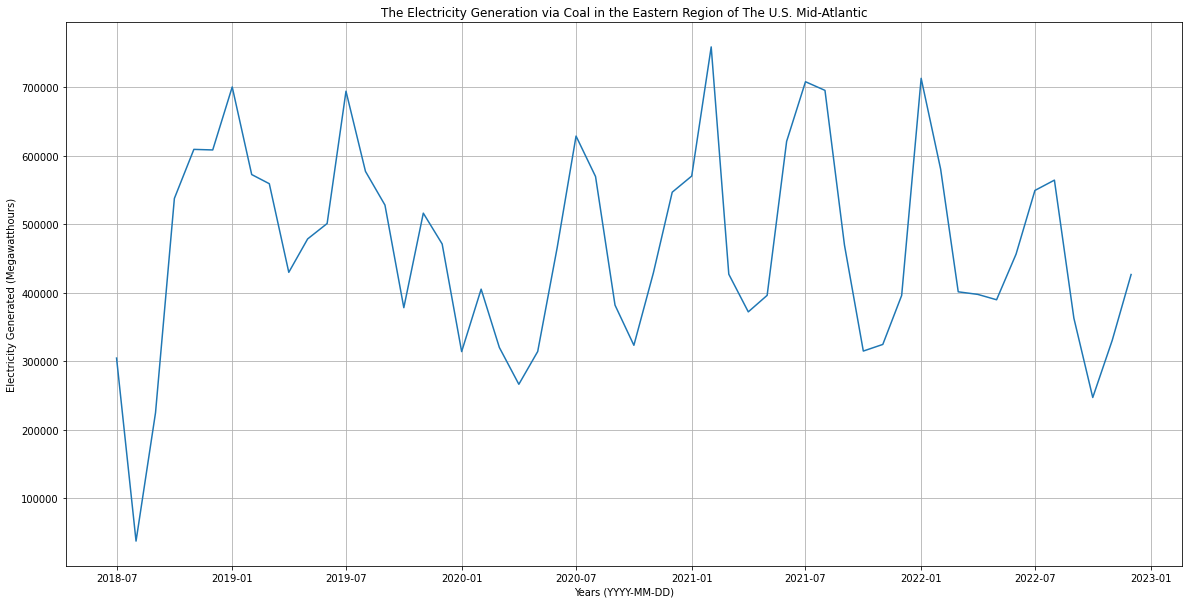

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(col)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

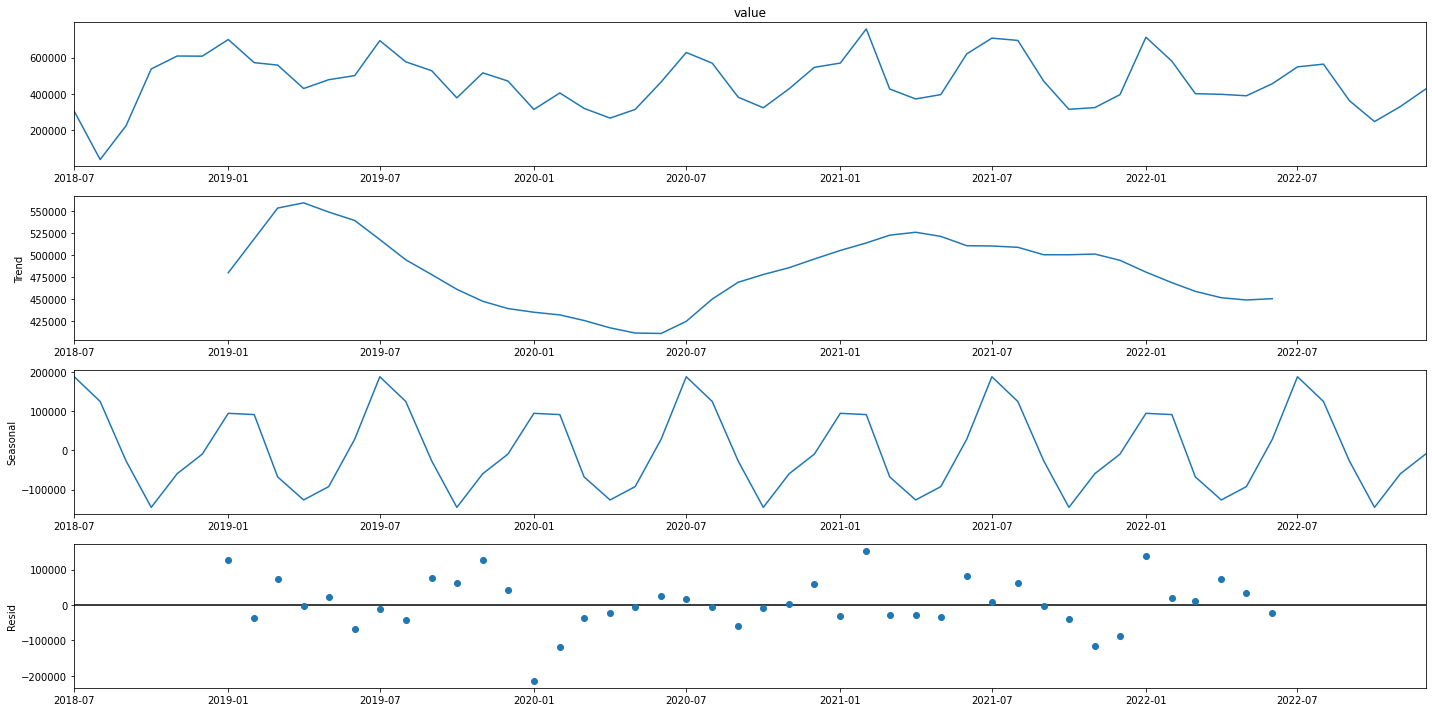

In [5]:
decomposition = sm.tsa.seasonal_decompose(col, model='additive')
decomposition.plot()
plt.show()

In [6]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(col,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1541.3831748519553
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1168.0985144578465
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1107.4774797795483
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2678.0108939596157
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1137.5686136760412
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1139.1865710761886
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:785.0936654003444
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:781.7849597211806
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1479.0871913007898
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1133.0827552601386
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1058.3408395516085
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2612.055017521986
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1185.4570193514337
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1133.8684941606741
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:786.8391579345092
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:735.6791778220828
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1379.0078112096696
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1055.63559746382

In [7]:
mod = sm.tsa.statespace.SARIMAX(col,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0065      1.684      0.004      0.997      -3.294       3.307
ma.L1          0.1825      1.720      0.106      0.916      -3.189       3.554
ar.S.L12      -0.5329      0.202     -2.638      0.008      -0.929      -0.137
ma.S.L12       0.1792      0.396      0.453      0.651      -0.597       0.955
sigma2      1.288e+10   3.94e-10   3.27e+19      0.000    1.29e+10    1.29e+10


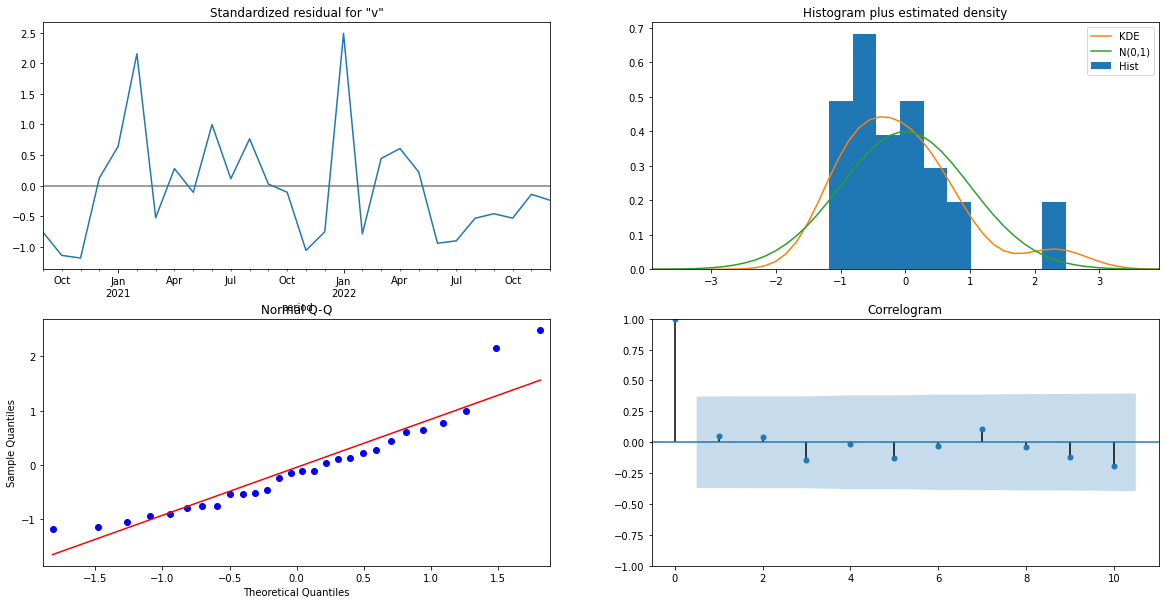

In [8]:
results.plot_diagnostics()
plt.show()

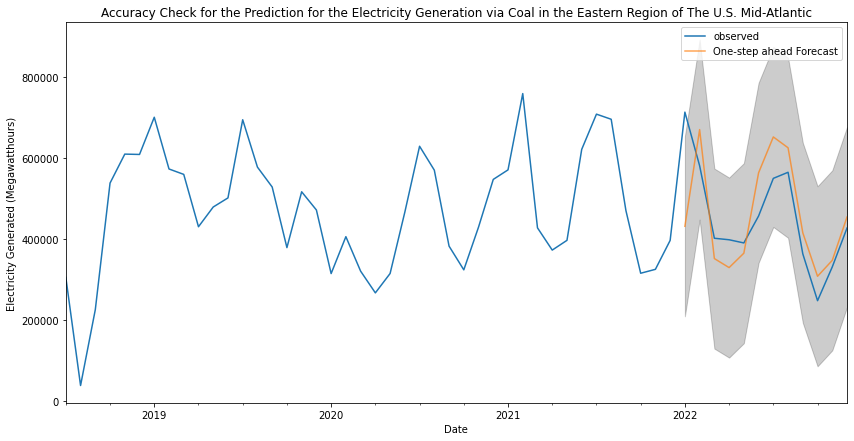

In [9]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = col.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [10]:
col_forecasted = pred.predicted_mean
col_truth = col['2022-01-01':]
mse = ((col_forecasted - col_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10692852838.68


In [11]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 103406.25


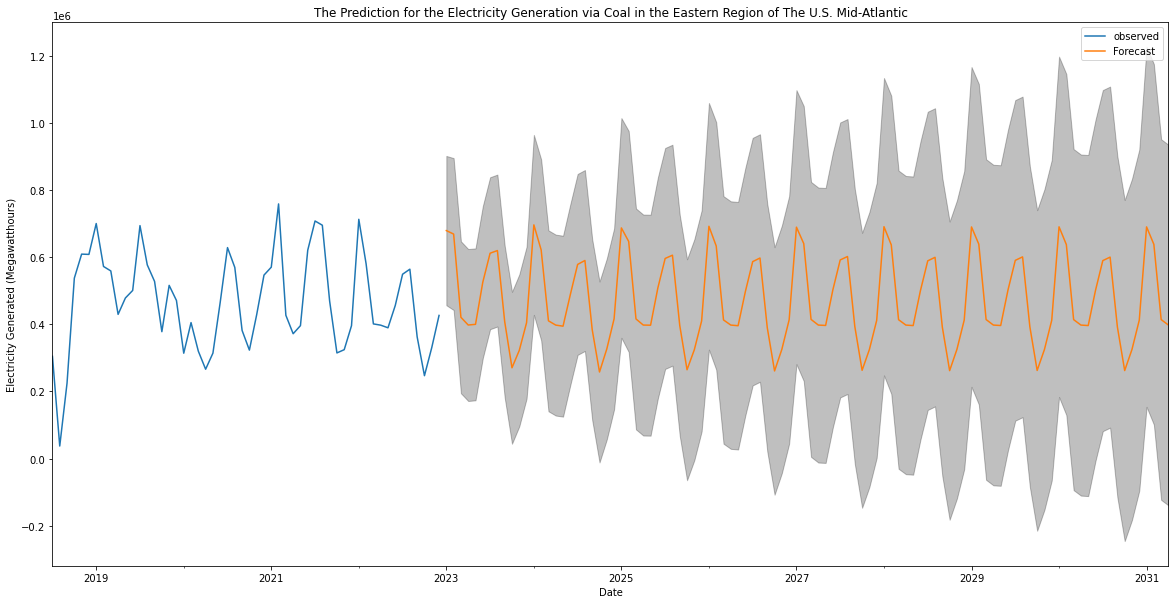

In [12]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = col.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electricity Generation via Coal in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [13]:
nucUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=NUC&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(nucUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

nucDf = pd.DataFrame(json_data.get('response').get('data'))
nucDf['period'] = pd.to_datetime(nucDf['period'])

nucDf = nucDf.sort_values('period')
nucDf.isnull().sum()

nucDf = nucDf.groupby('period')['value'].sum().reset_index()

nucDf = nucDf.set_index('period')
nucDf.index

nuc = nucDf['value'].resample('MS').mean()

nucDf

The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,803906
2018-07-02,803323
2018-07-03,811917
2018-07-04,814756
2018-07-05,812172
...,...
2022-12-07,770626
2022-12-08,771484
2022-12-09,772929


>**Past Data, Present Data, and Prediction of the Energy Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic**

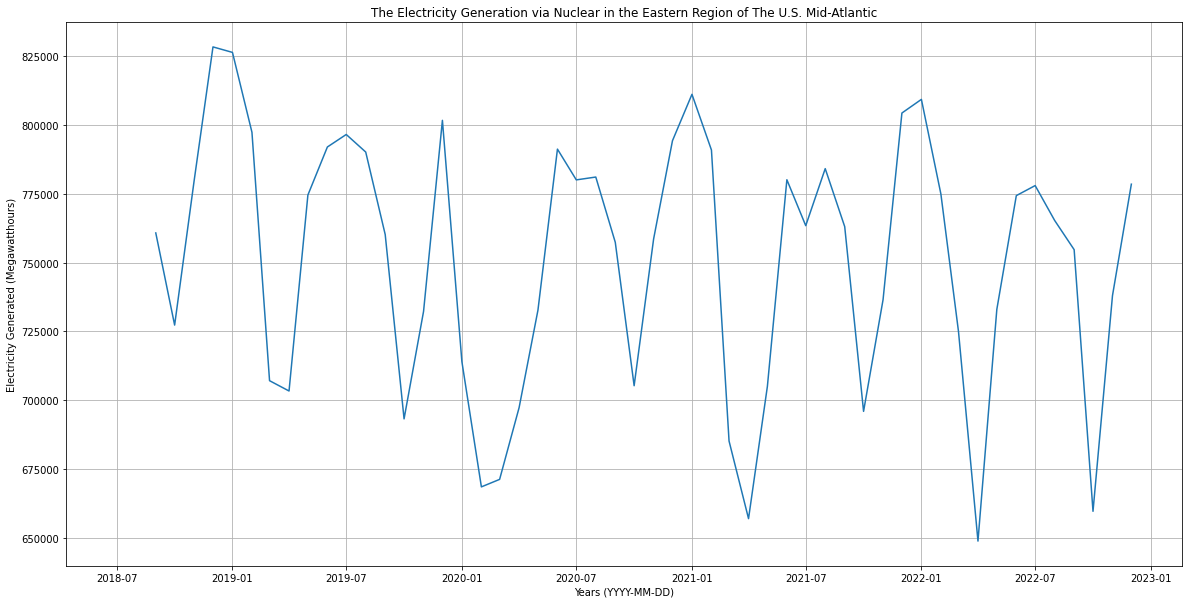

In [14]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(nuc)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

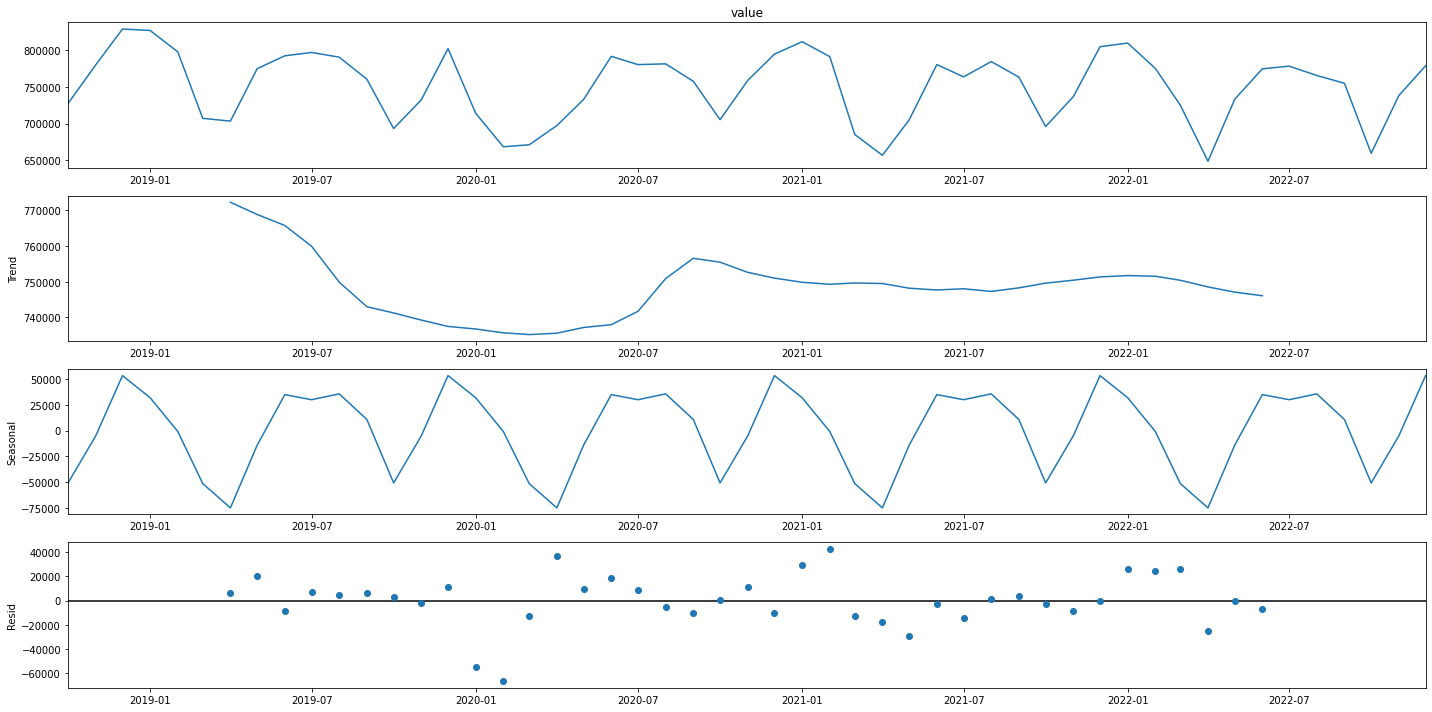

In [15]:
decomposition = sm.tsa.seasonal_decompose(nuc['2018-10-01':], model='additive')
decomposition.plot()
plt.show()

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(nuc['2018-10-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1526.8496029509297
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1505.9957976043404
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:945.9461869571177
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1761.4165425543713
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1305.4997563950462
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1294.7788240275336
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:938.5019807270533
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1787.0586910207007
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1493.4594410447605
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1578.0038976386325
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:951.372410389275
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1676.8948363649026
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1489.542406819929
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1496.4304713729116
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:933.8253244630364
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1736.2934310677194
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1224.7016246330556
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1275.344843229076

In [17]:
mod = sm.tsa.statespace.SARIMAX(nuc['2018-10-01':],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0095      0.108     -0.088      0.930      -0.222       0.203
ar.S.L12      -0.0740      0.043     -1.707      0.088      -0.159       0.011
sigma2      1.664e+09   1.04e-11    1.6e+20      0.000    1.66e+09    1.66e+09


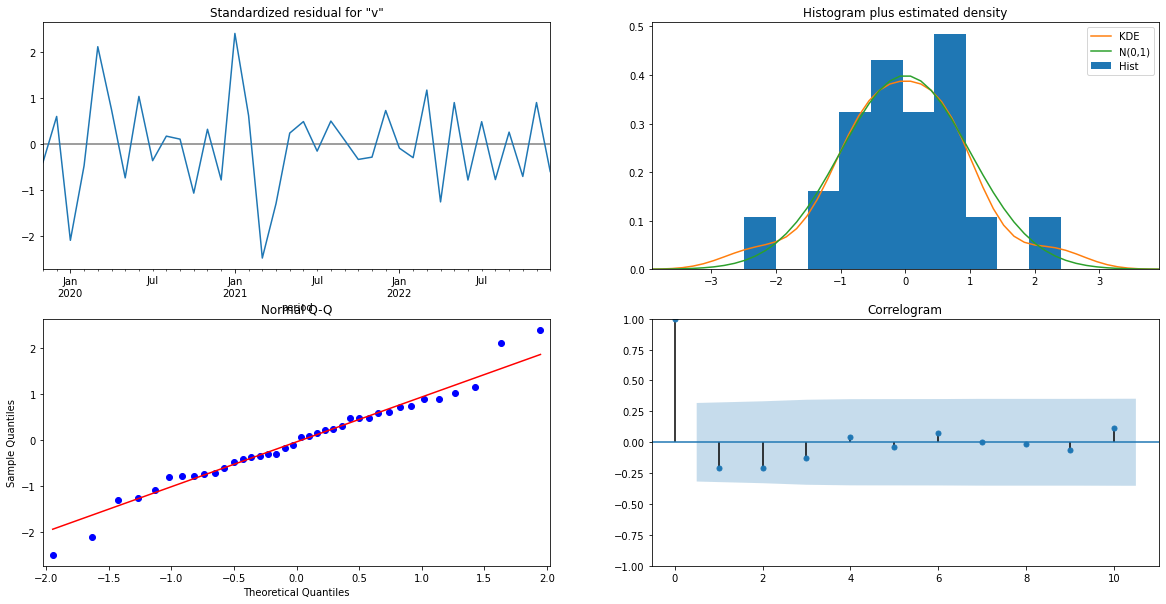

In [18]:
results.plot_diagnostics()
plt.show()

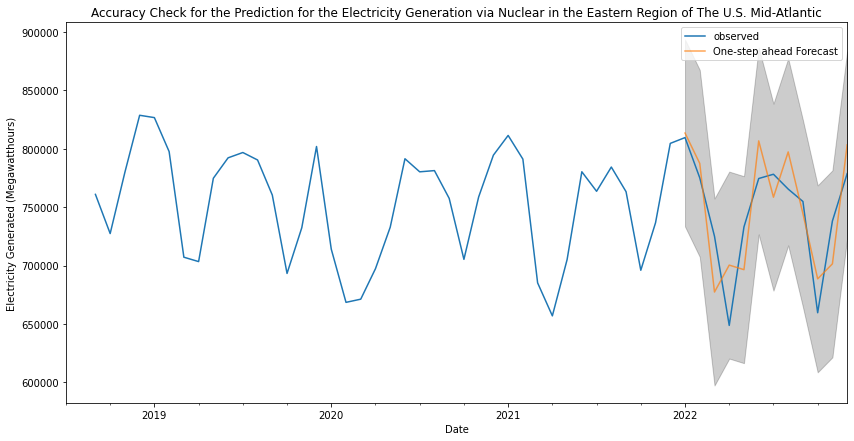

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = nuc['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [20]:
nuc_forecasted = pred.predicted_mean
nuc_truth = nuc['2022-01-01':]
mse = ((nuc_forecasted - nuc_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 980742593.41


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 31316.81


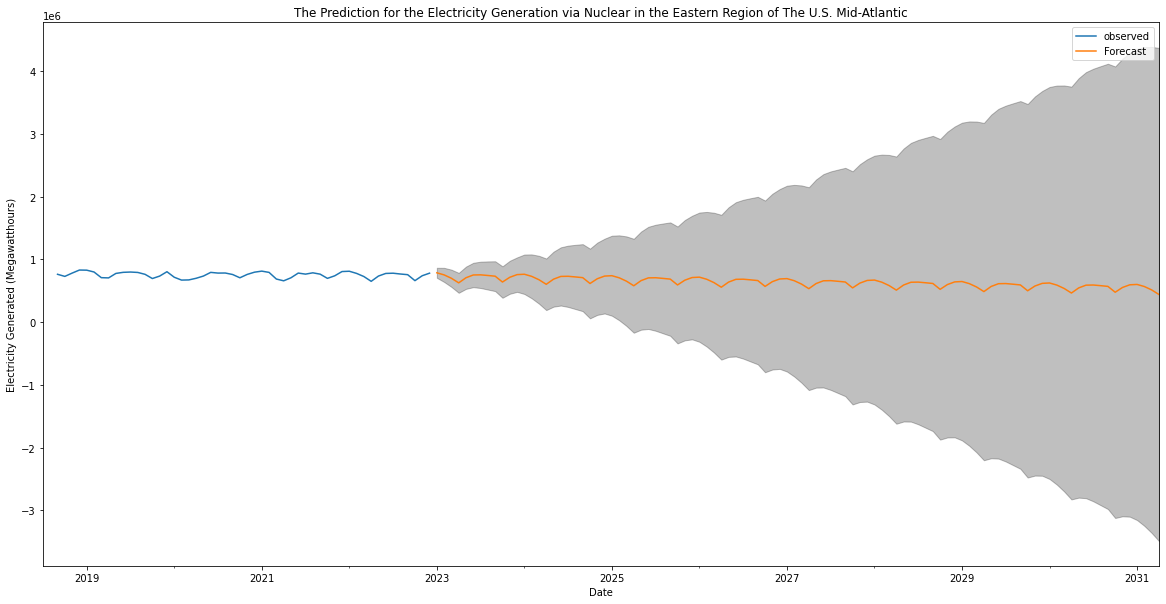

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = nuc.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electricity Generation via Nuclear in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [23]:
watUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=WAT&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(watUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

watDf = pd.DataFrame(json_data.get('response').get('data'))
watDf['period'] = pd.to_datetime(watDf['period'])

watDf = watDf.sort_values('period')
watDf.isnull().sum()

watDf = watDf.groupby('period')['value'].sum().reset_index()

watDf = watDf.set_index('period')
watDf.index

wat = watDf['value'].resample('MS').mean()

watDf

The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,54169
2018-07-02,65488
2018-07-03,58860
2018-07-04,51415
2018-07-05,59848
...,...
2022-12-07,41240
2022-12-08,42436
2022-12-09,47638


>**Past Data, Present Data, and Prediction of the Energy Generation via Water in the Eastern Region of The U.S. Mid-Atlantic**

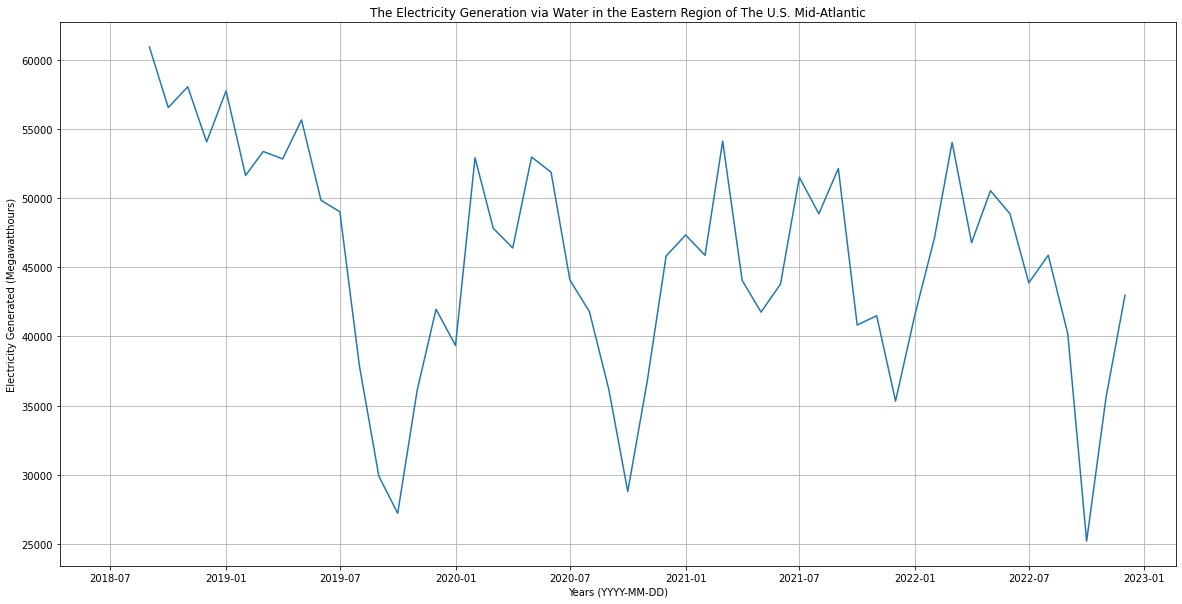

In [24]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(wat)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

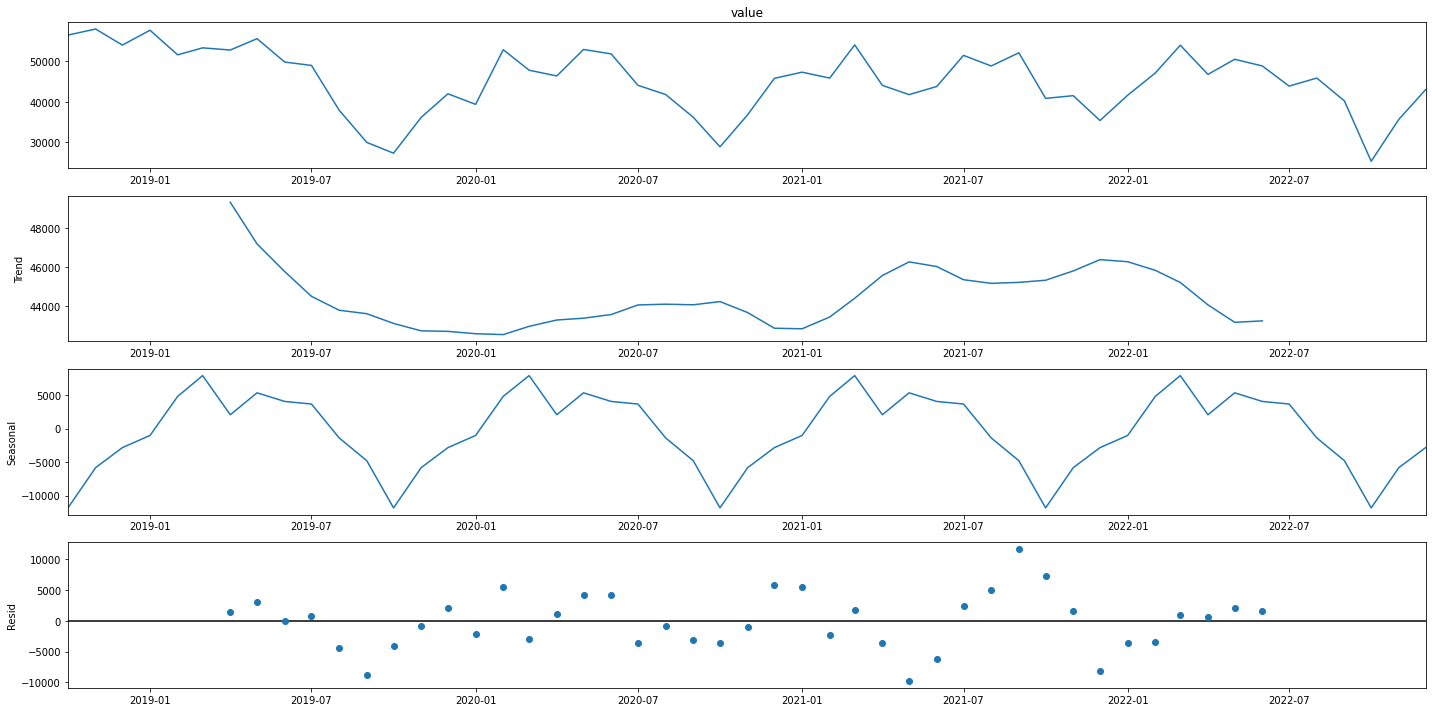

In [25]:
decomposition = sm.tsa.seasonal_decompose(wat['2018-10-01':], model='additive')
decomposition.plot()
plt.show()

In [26]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(wat['2018-10-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1216.8022454398003
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:892.1635321432378
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:798.5524468866419
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1045.608338331115
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:826.2535631711133
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:793.3299396259358
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:559.9742887524976
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1051.2323184238207
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1160.2709077365528
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:872.1357351723925
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:765.9007055070821
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1110.3113045640296
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:914.1043360109837
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:868.9456368811655
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:555.8903104190655
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:888.2057620762882
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1000.7824886290797
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:760.3653088899019
ARIMA

In [27]:
mod = sm.tsa.statespace.SARIMAX(wat['2018-10-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7630      0.171      4.466      0.000       0.428       1.098
ma.L1         -1.0774      0.124     -8.718      0.000      -1.320      -0.835
ar.S.L12       0.3163      0.384      0.824      0.410      -0.436       1.069
ma.S.L12      -0.5996      0.472     -1.272      0.204      -1.524       0.325
sigma2      5.906e+07   2.99e-09   1.97e+16      0.000    5.91e+07    5.91e+07


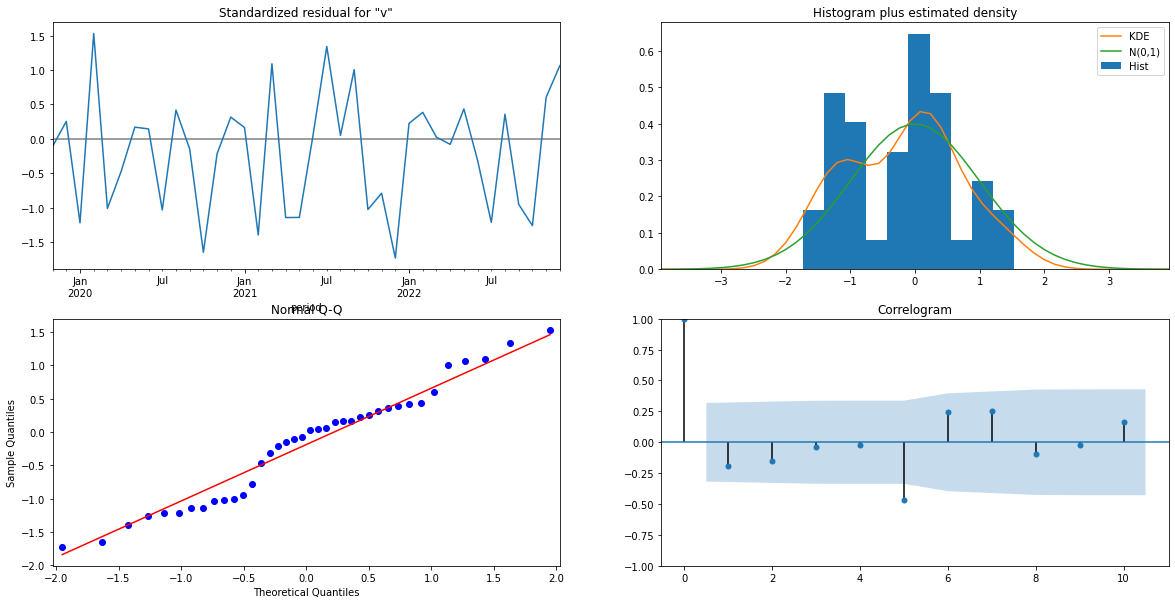

In [28]:
results.plot_diagnostics()
plt.show()

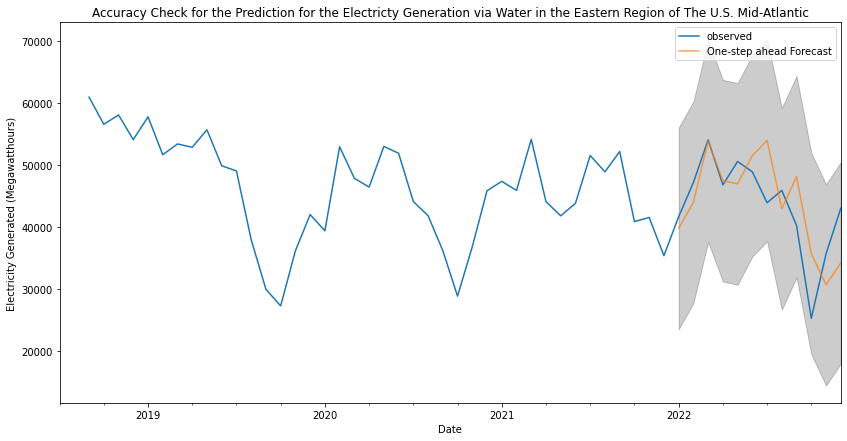

In [29]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = wat['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricty Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [30]:
wat_forecasted = pred.predicted_mean
wat_truth = wat['2022-01-01':]
mse = ((wat_forecasted - wat_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34832755.28


In [31]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 5901.93


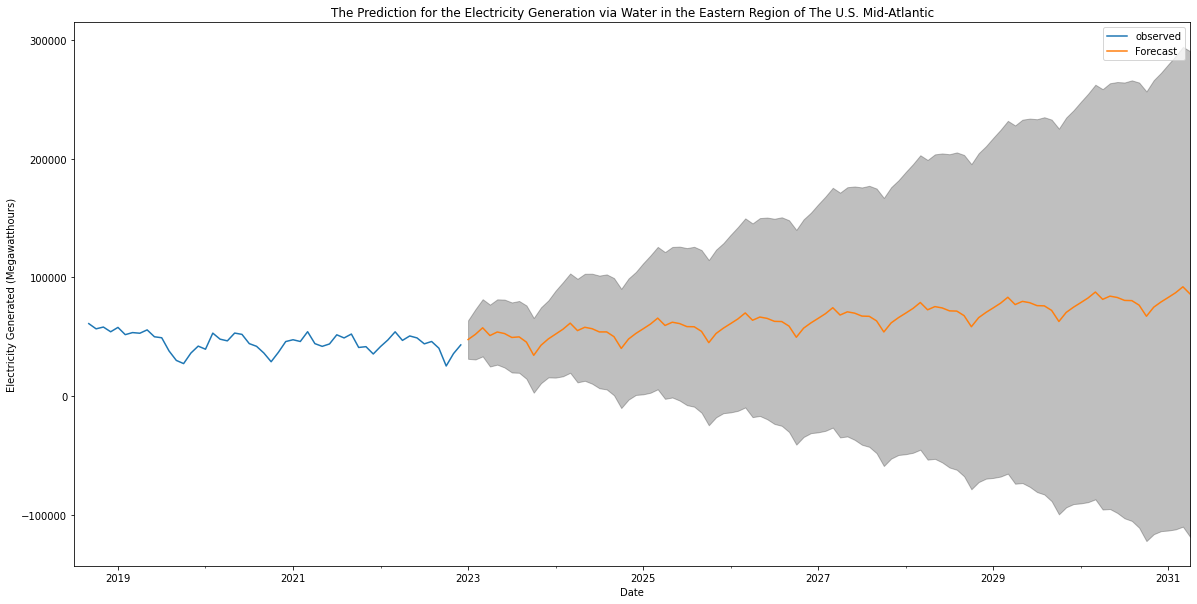

In [32]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = wat['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electricity Generation via Water in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [33]:
ngUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=NG&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(ngUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

ngDf = pd.DataFrame(json_data.get('response').get('data'))
ngDf['period'] = pd.to_datetime(ngDf['period'])

ngDf = ngDf.sort_values('period')
ngDf.isnull().sum()

ngDf = ngDf.groupby('period')['value'].sum().reset_index()

ngDf = ngDf.set_index('period')
ngDf.index

ng = ngDf['value'].resample('MS').mean()

ngDf

The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,916254
2018-07-02,1030842
2018-07-03,1013122
2018-07-04,920407
2018-07-05,1031095
...,...
2022-12-07,893228
2022-12-08,867920
2022-12-09,905776


>**Past Data, Present Data, and Prediction of the Energy Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic**

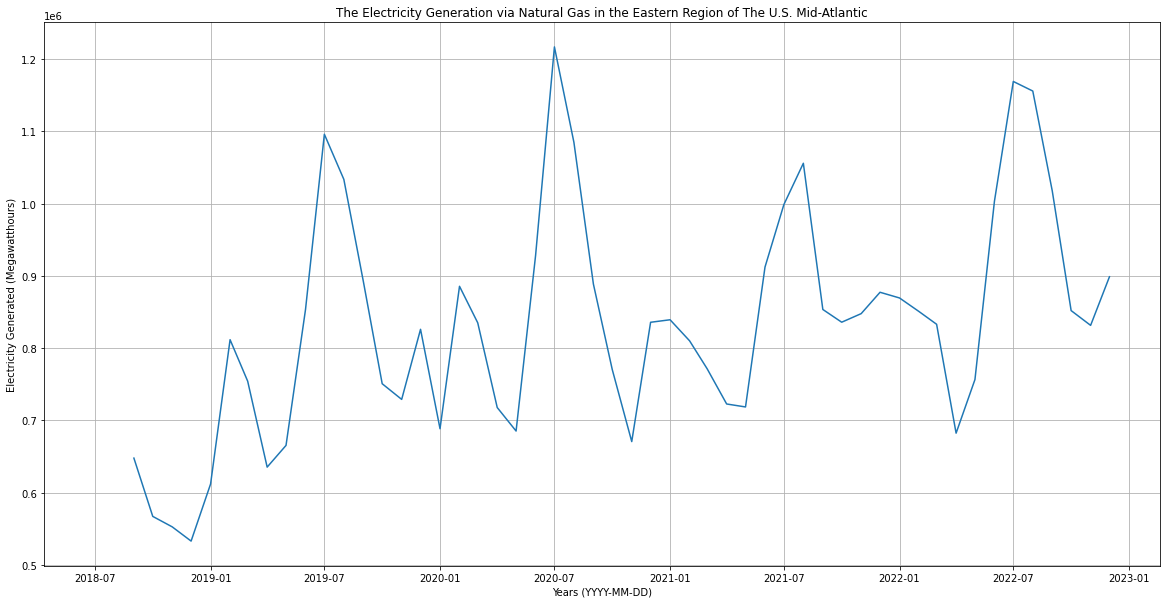

In [34]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(ng)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

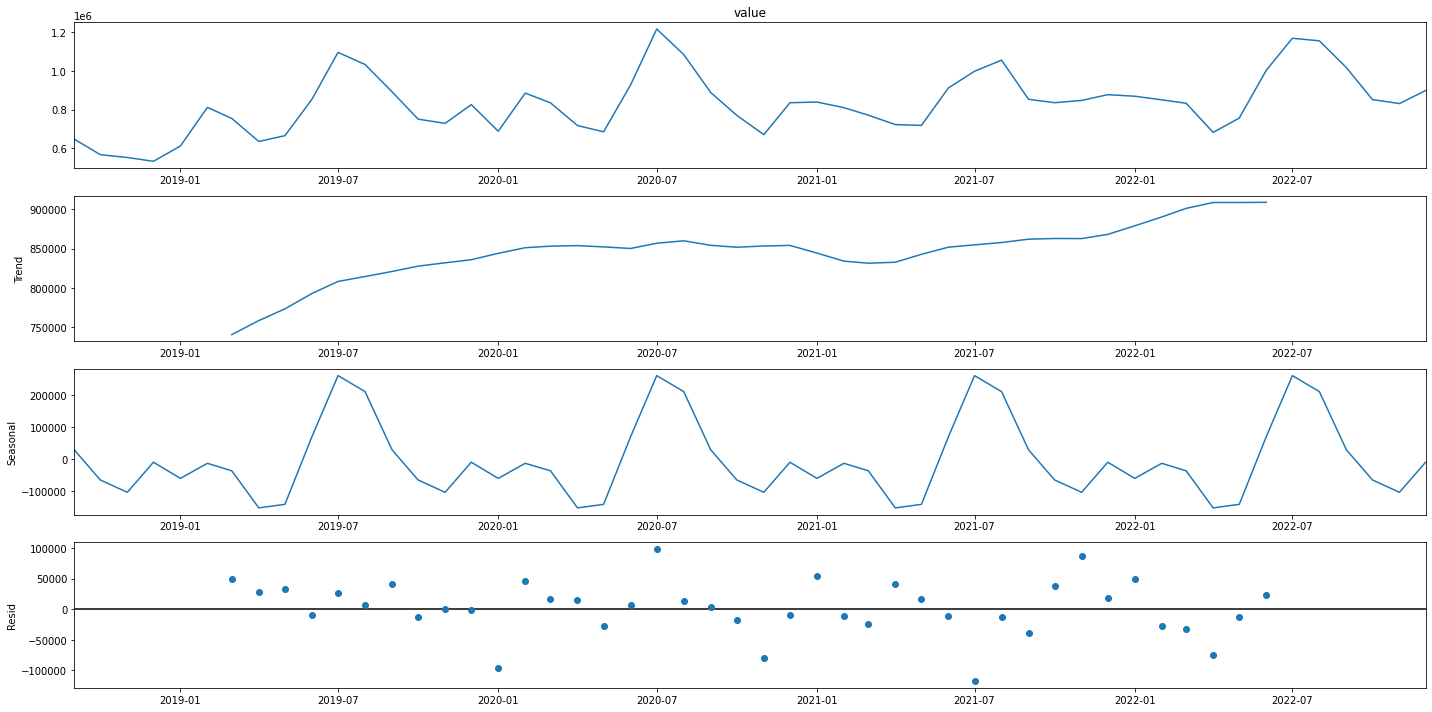

In [35]:
decomposition = sm.tsa.seasonal_decompose(ng['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [36]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ng['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1539.4799595063284
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1155.436273157769
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1012.9076670657449
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1188.960514342776
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1037.3855376341226
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1018.1953660202256
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:717.0746120821277
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1119.8249477057416
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1476.7161060729716
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1117.4094939823597
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:976.5817460306799
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2376.5163298060215
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1172.374871919948
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1116.0210844467026
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:714.9277392321094
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2397.7201038040416
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1318.8172009021016
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:984.5223895099356

In [37]:
mod = sm.tsa.statespace.SARIMAX(ng['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5776      0.629      0.918      0.359      -0.656       1.811
ma.L1         -0.6543      0.618     -1.059      0.290      -1.866       0.557
ar.S.L12       0.5977      0.158      3.779      0.000       0.288       0.908
ma.S.L12      -0.9697      0.348     -2.790      0.005      -1.651      -0.288
sigma2      6.841e+09   5.74e-11   1.19e+20      0.000    6.84e+09    6.84e+09


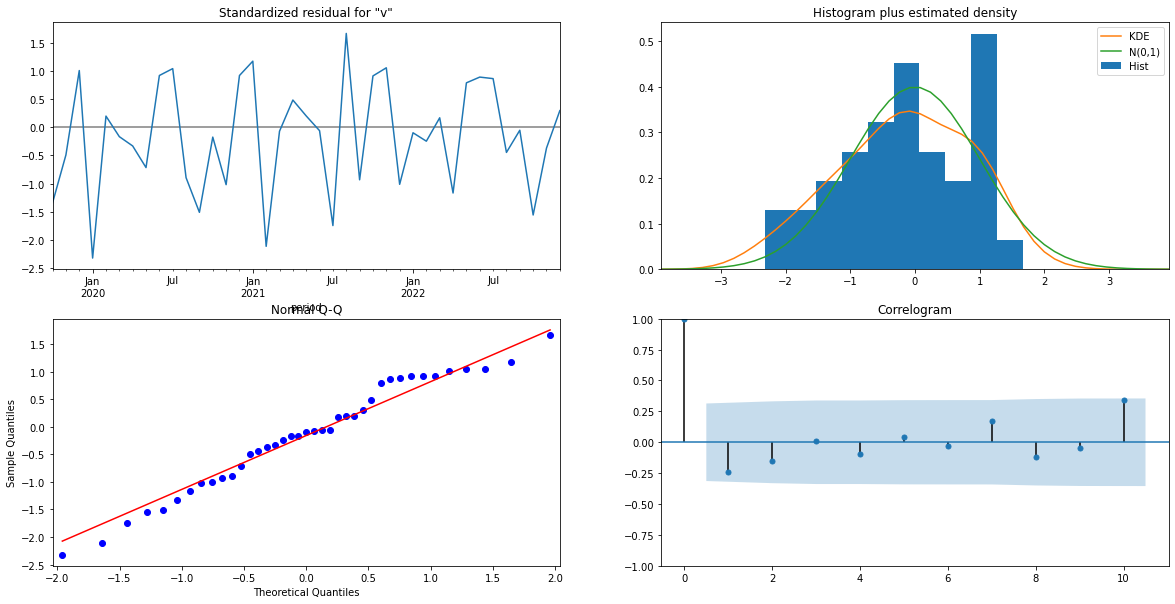

In [38]:
results.plot_diagnostics()
plt.show()

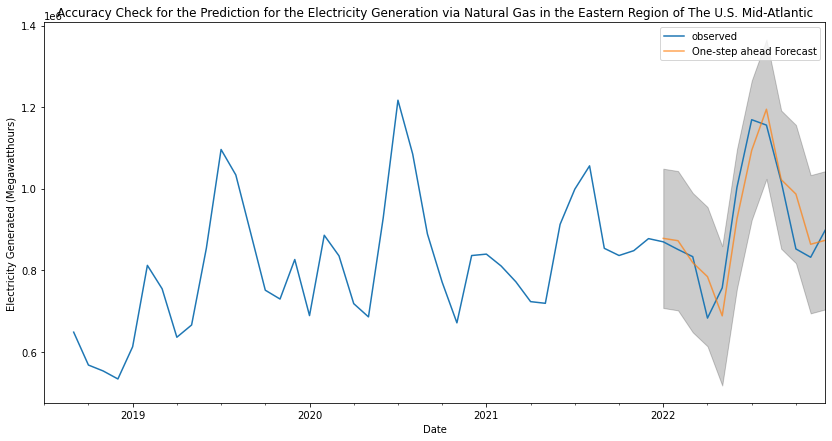

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = ng['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [40]:
ng_forecasted = pred.predicted_mean
ng_truth = ng['2022-01-01':]
mse = ((ng_forecasted - ng_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4066231140.43


In [41]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 63767.01


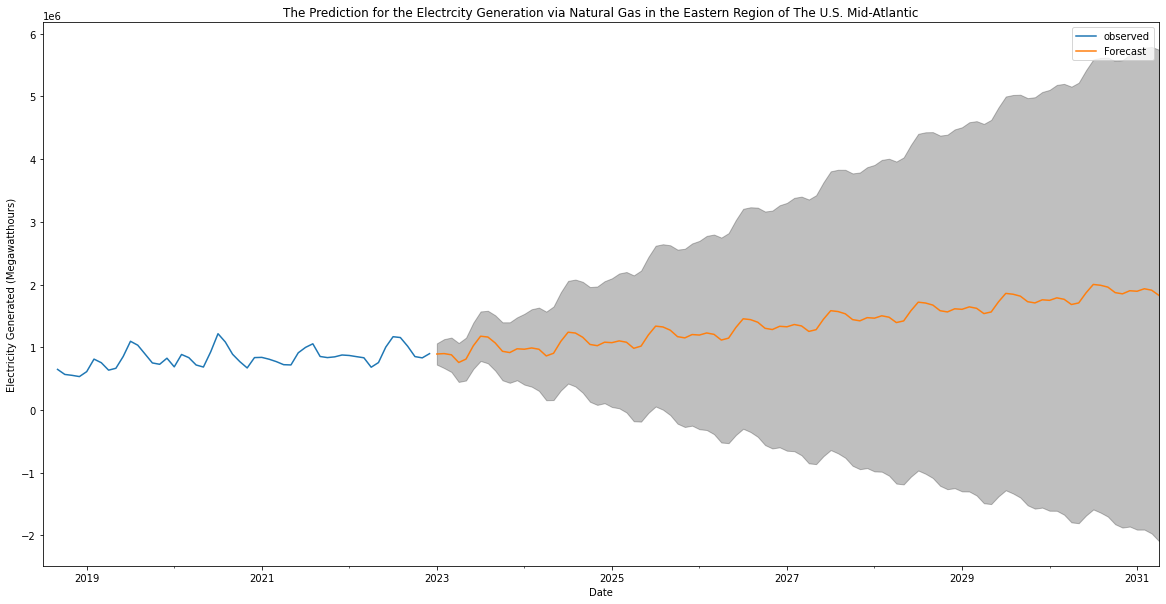

In [42]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = ng['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Natural Gas in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [43]:
oilUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=OIL&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(oilUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

oilDf = pd.DataFrame(json_data.get('response').get('data'))
oilDf['period'] = pd.to_datetime(oilDf['period'])

oilDf = oilDf.sort_values('period')
oilDf.isnull().sum()

oilDf = oilDf.groupby('period')['value'].sum().reset_index()

oilDf = oilDf.set_index('period')
oilDf.index

oil = oilDf['value'].resample('MS').mean()

oilDf

The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,9290
2018-07-02,7913
2018-07-03,12365
2018-07-04,4352
2018-07-05,4823
...,...
2022-12-07,4535
2022-12-08,4131
2022-12-09,4626


>**Past Data, Present Data, and Prediction of the Energy Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic**

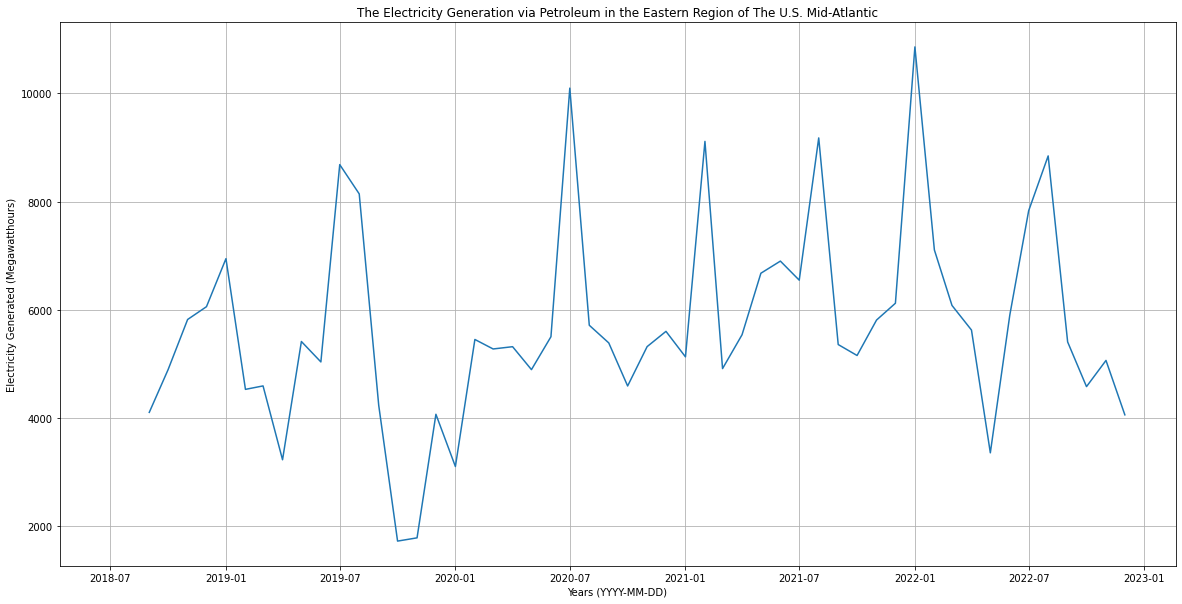

In [44]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(oil)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

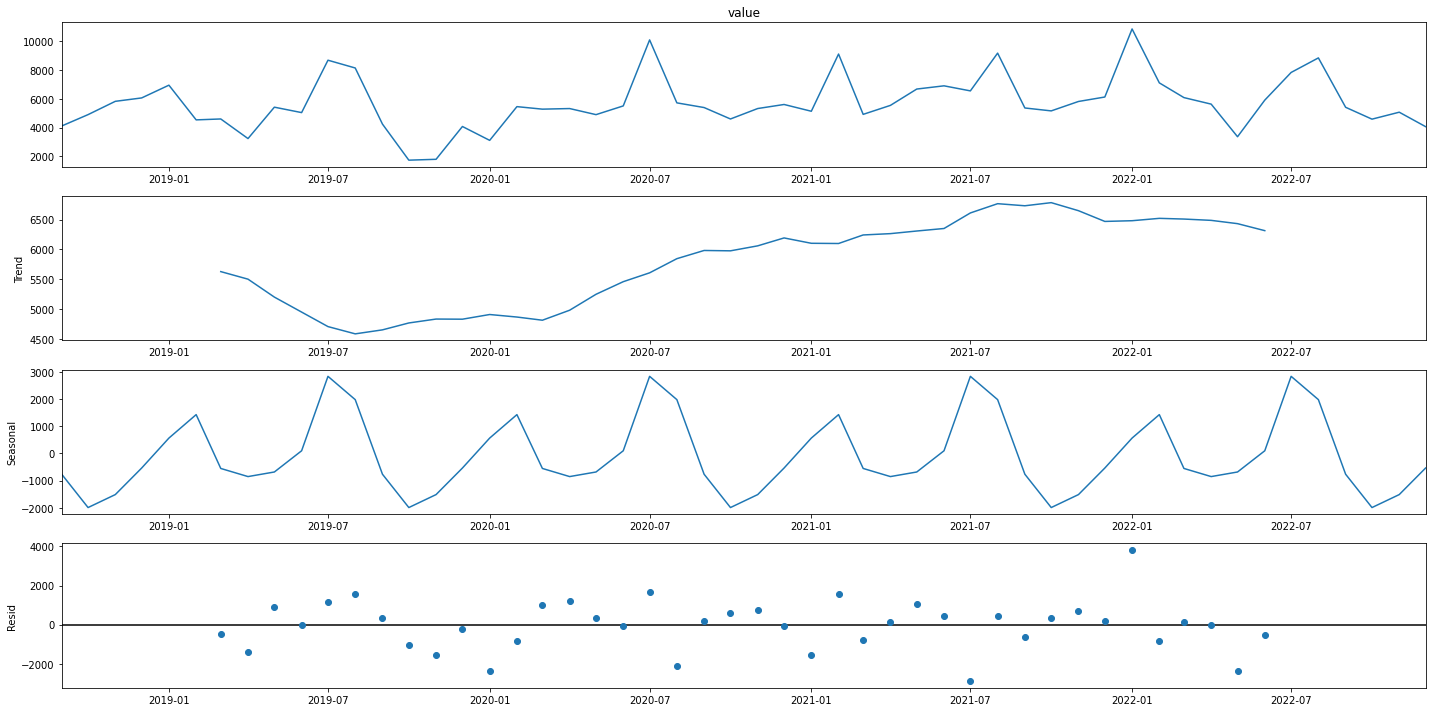

In [45]:
decomposition = sm.tsa.seasonal_decompose(oil['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [46]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(oil['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1034.5262452344332
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:774.6517537322742
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:712.9881623523333
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1093.0123045192038
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:731.9439813399731
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:718.883260607729
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:508.60528146978226
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1054.7802144094594
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:967.157230504534
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:722.5394435905421
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:695.1045525608699
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1117.72823680997
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:733.034890405588
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:691.9866749341026
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:510.3619331245673
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1131.9538170054986
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:910.7178097499736
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:695.556745468368
ARIMA(0, 1

In [47]:
mod = sm.tsa.statespace.SARIMAX(oil['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3078      0.167      1.847      0.065      -0.019       0.634
ma.L1         -1.0605      0.324     -3.271      0.001      -1.696      -0.425
ar.S.L12      -0.5071      0.185     -2.747      0.006      -0.869      -0.145
sigma2      3.675e+06   1.75e+06      2.100      0.036    2.46e+05     7.1e+06


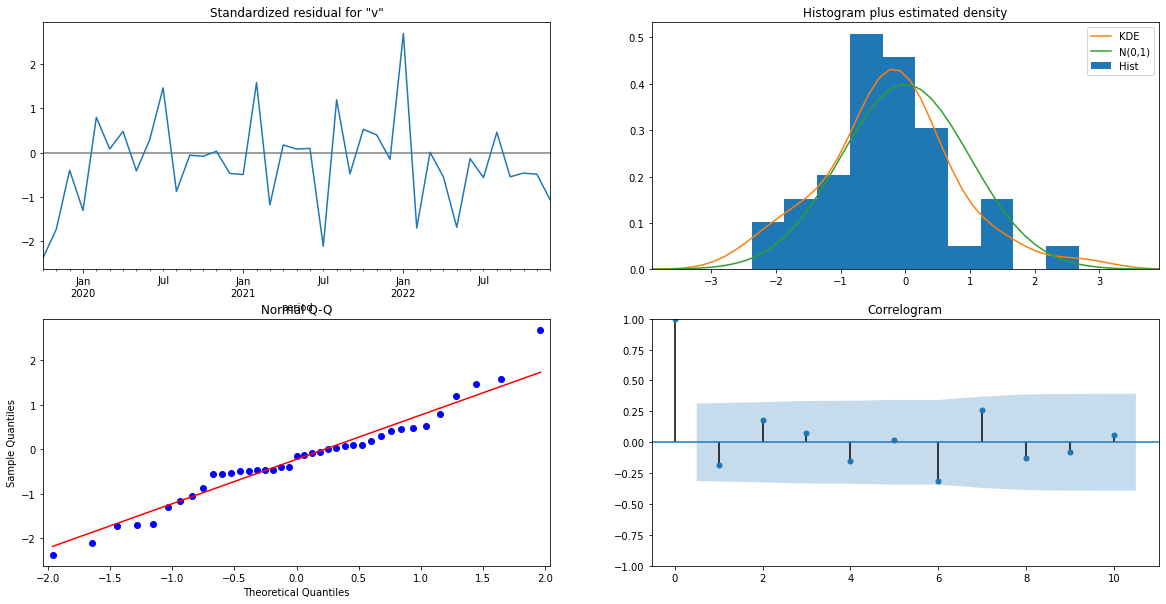

In [48]:
results.plot_diagnostics()
plt.show()

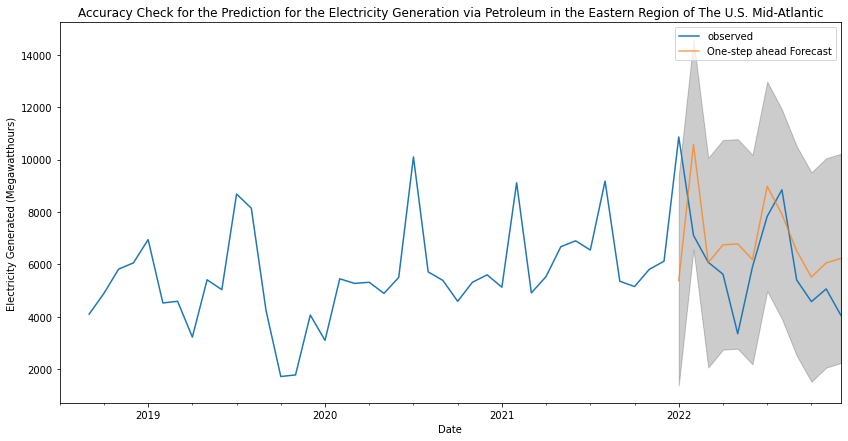

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = oil['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [50]:
oil_forecasted = pred.predicted_mean
oil_truth = oil['2022-01-01':]
mse = ((oil_forecasted - oil_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 5416759.39


In [51]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2327.39


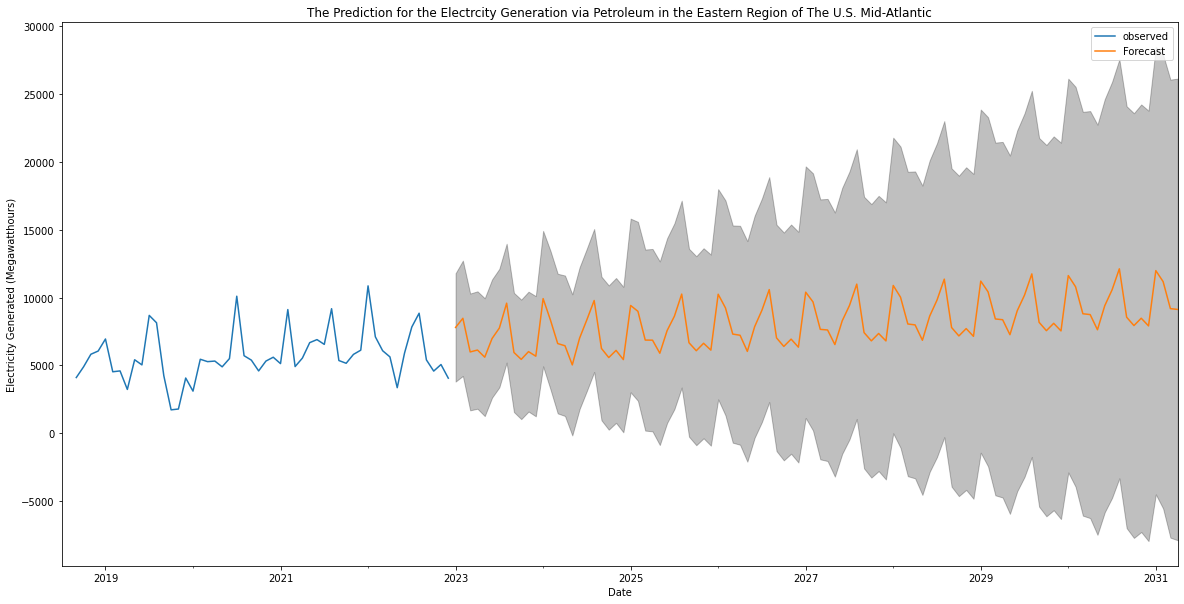

In [52]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = oil['2018':].plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Petroleum in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [53]:
sunUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=SUN&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(sunUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

sunDf = pd.DataFrame(json_data.get('response').get('data'))
sunDf['period'] = pd.to_datetime(sunDf['period'])

sunDf = sunDf.sort_values('period')
sunDf.isnull().sum()

sunDf = sunDf.groupby('period')['value'].sum().reset_index()

sunDf = sunDf.set_index('period')
sunDf.index

sun = sunDf['value'].resample('MS').mean()

sunDf

The Electricity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,7797
2018-07-02,8081
2018-07-03,7507
2018-07-04,5985
2018-07-05,6669
...,...
2022-12-07,2959
2022-12-08,5699
2022-12-09,9744


>**Past Data, Present Data, and Prediction of the Energy Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic**

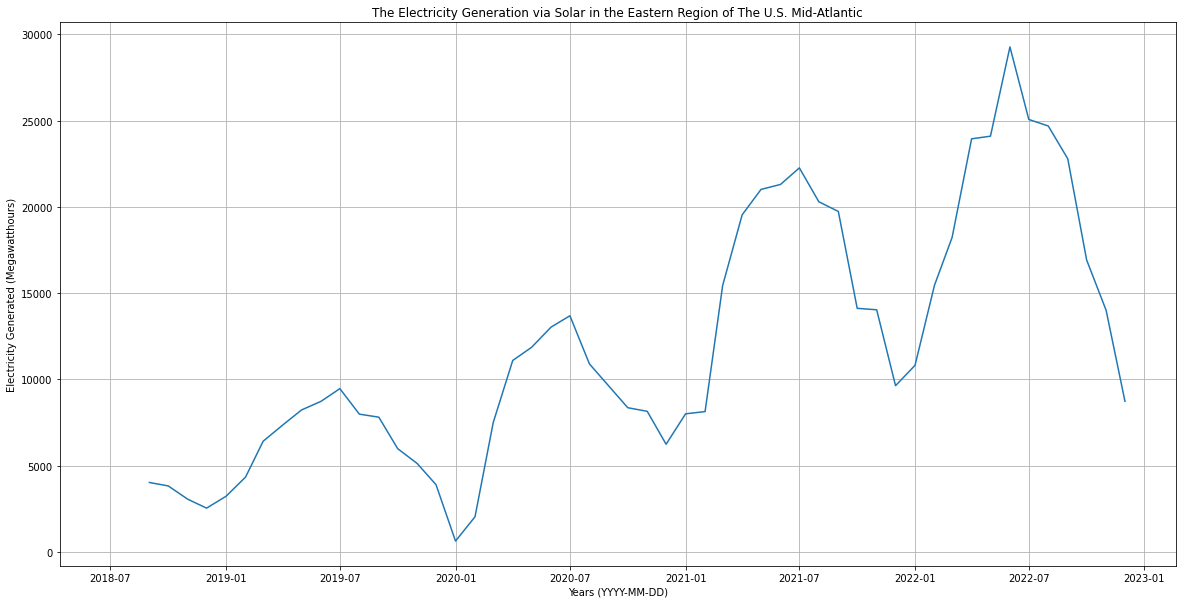

In [54]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(sun)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

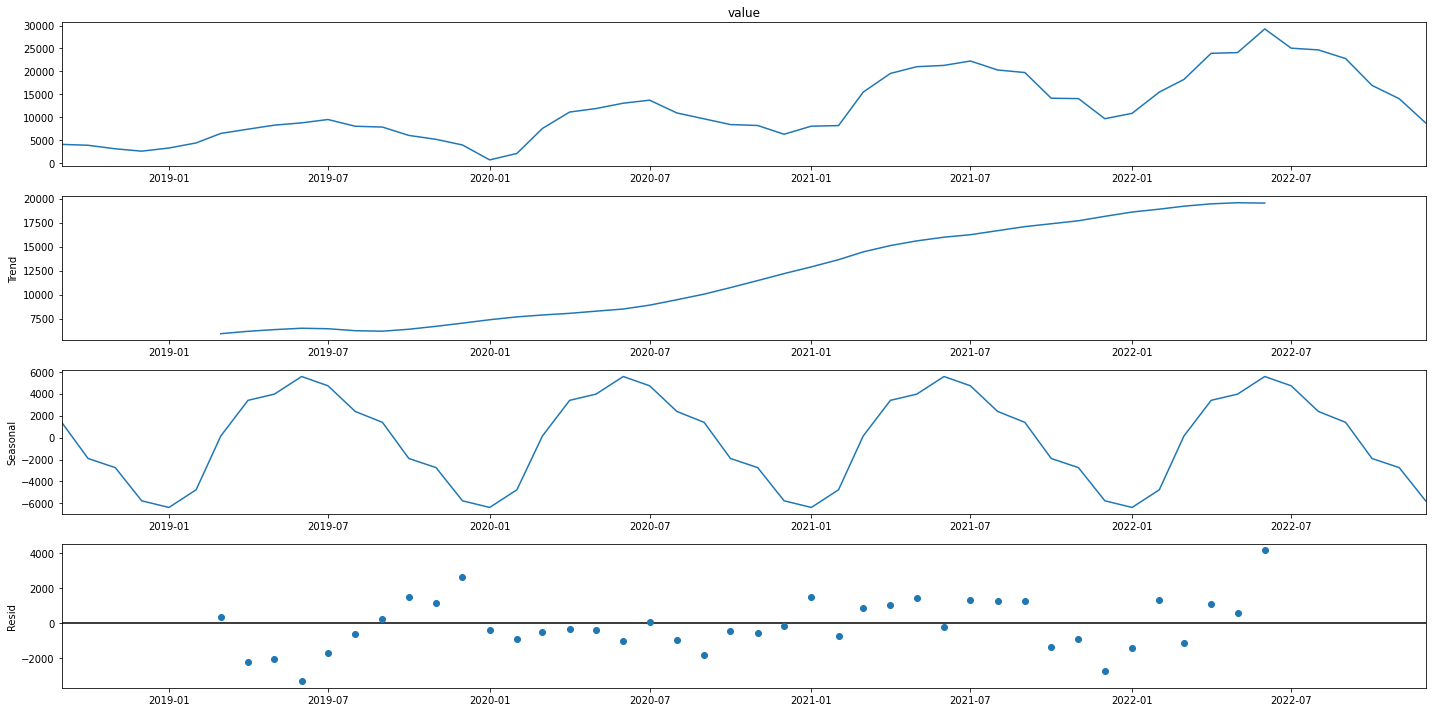

In [55]:
decomposition = sm.tsa.seasonal_decompose(sun['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [56]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sun['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1121.071671213072
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:853.003915547861
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:779.9391092351551
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:764.0373793029556
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:768.5757815362876
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:754.6083007052603
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:556.2710741781319
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:966.1103029641005
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1043.885463433123
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:808.8740190877871
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:743.8158722527536
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:960.4802388228528
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:755.572193061671
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:720.2359601891079
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:551.1219502488213
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1058.2866658016562
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:939.114865810789
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:710.1380568041935
ARIMA(0, 1, 

In [57]:
mod = sm.tsa.statespace.SARIMAX(sun['2018-09-01':],
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3021      0.170     -1.779      0.075      -0.635       0.031
ar.S.L12      -0.0316      0.206     -0.153      0.878      -0.435       0.372
sigma2      4.802e+06    1.2e+06      4.011      0.000    2.46e+06    7.15e+06


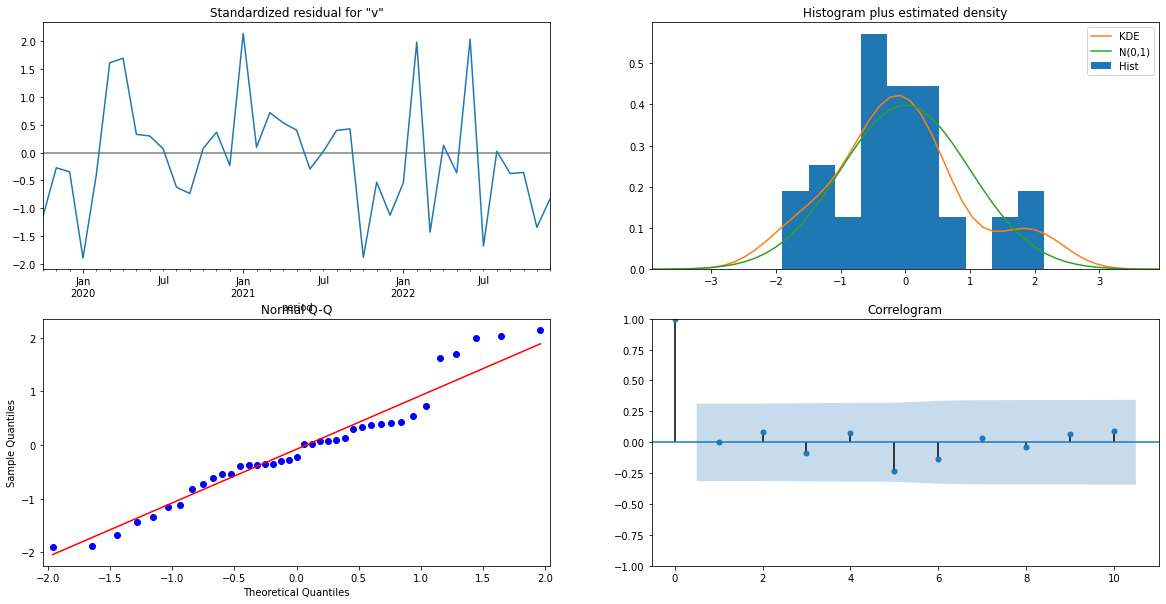

In [58]:
results.plot_diagnostics()
plt.show()

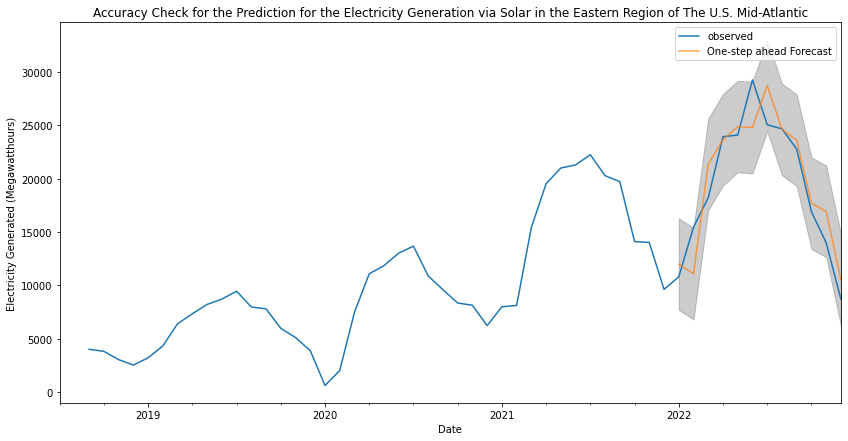

In [59]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = sun['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [60]:
sun_forecasted = pred.predicted_mean
sun_truth = sun['2022-01-01':]
mse = ((sun_forecasted - sun_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6476869.67


In [61]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2544.97


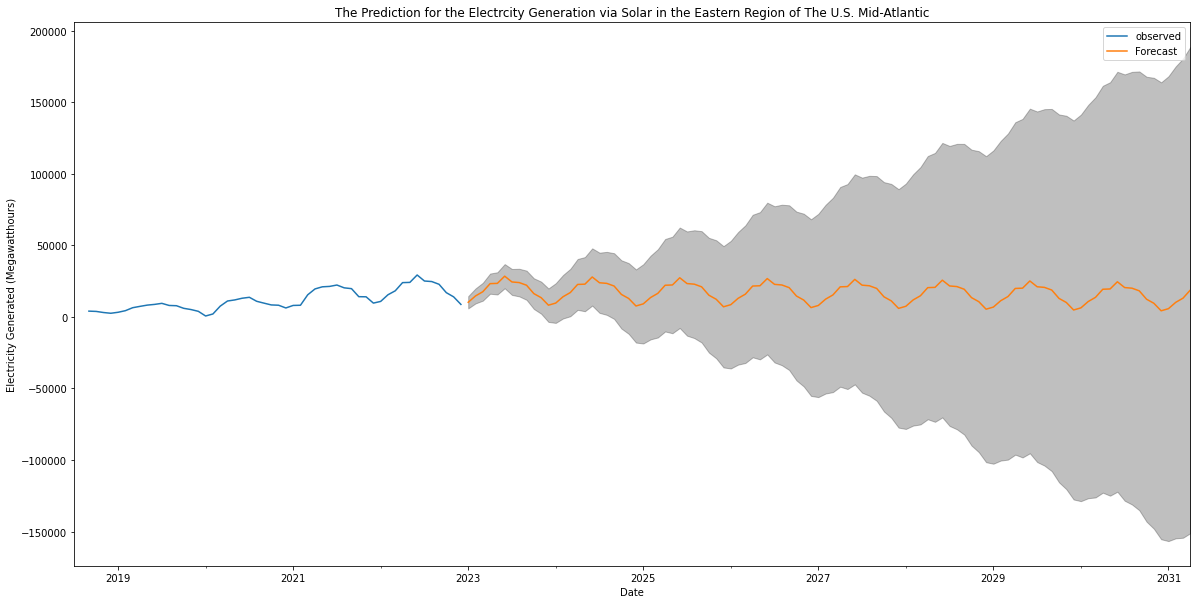

In [62]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = sun.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Solar in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [63]:
wndUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=WND&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(wndUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

wndDf = pd.DataFrame(json_data.get('response').get('data'))
wndDf['period'] = pd.to_datetime(wndDf['period'])

wndDf = wndDf.sort_values('period')
wndDf.isnull().sum()

wndDf = wndDf.groupby('period')['value'].sum().reset_index()

wndDf = wndDf.set_index('period')
wndDf.index

wnd = wndDf['value'].resample('MS').mean()

wndDf

The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,51429
2018-07-02,14217
2018-07-03,14028
2018-07-04,12712
2018-07-05,20718
...,...
2022-12-07,25674
2022-12-08,63619
2022-12-09,92434


>**Past Data, Present Data, and Prediction of the Energy Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic**

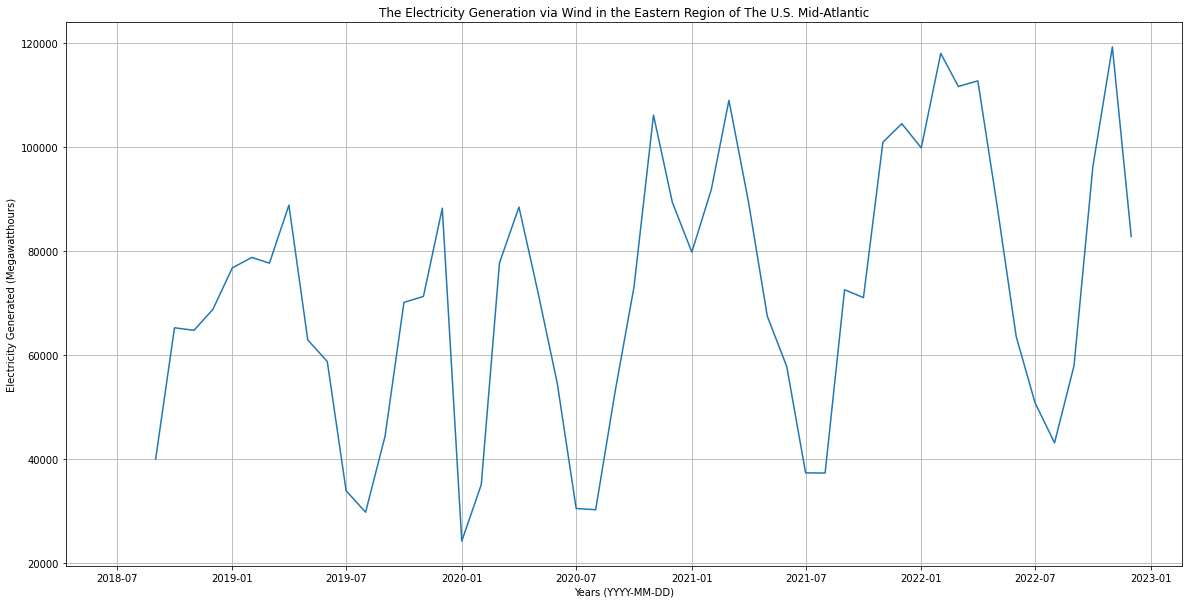

In [64]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(wnd)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

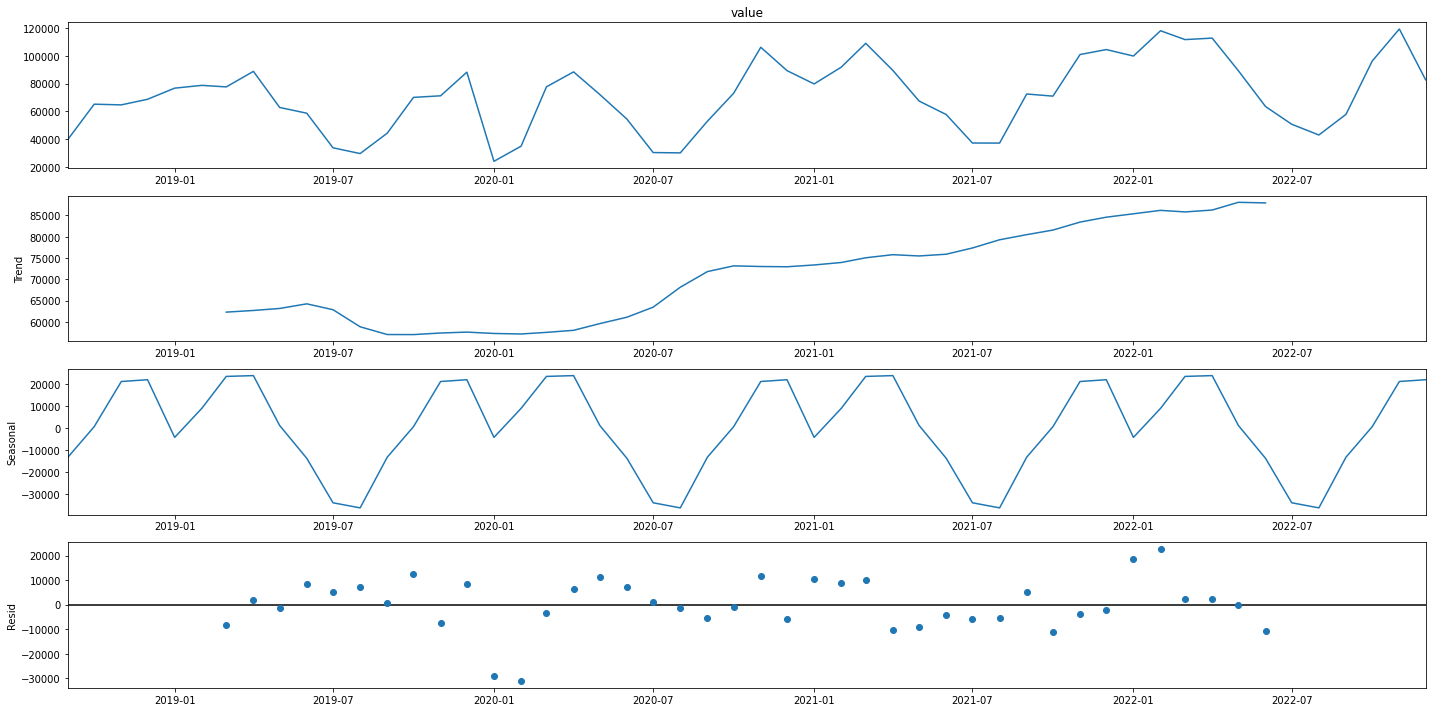

In [65]:
decomposition = sm.tsa.seasonal_decompose(wnd['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [66]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(wnd['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1293.497074934927
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:974.9710260548695
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:892.0588610688707
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:979.2508838954735
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:913.262131324677
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:916.7315862551278
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:641.4937467726713
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1315.247837409702
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2944.4209352272933
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:933.4731965282056
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:864.608685542751
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1203.2436466118918
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1034.6796865840452
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:975.100743107587
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:635.1863701468299
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1111.158538787406
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1138.3259997098692
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:868.7727795652576
ARIMA(0, 

In [67]:
mod = sm.tsa.statespace.SARIMAX(wnd['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3022      0.296      1.023      0.306      -0.277       0.881
ma.L1         -0.7755      0.188     -4.122      0.000      -1.144      -0.407
ar.S.L12      -0.4971      0.153     -3.259      0.001      -0.796      -0.198
sigma2      3.638e+08   9.27e-10   3.92e+17      0.000    3.64e+08    3.64e+08


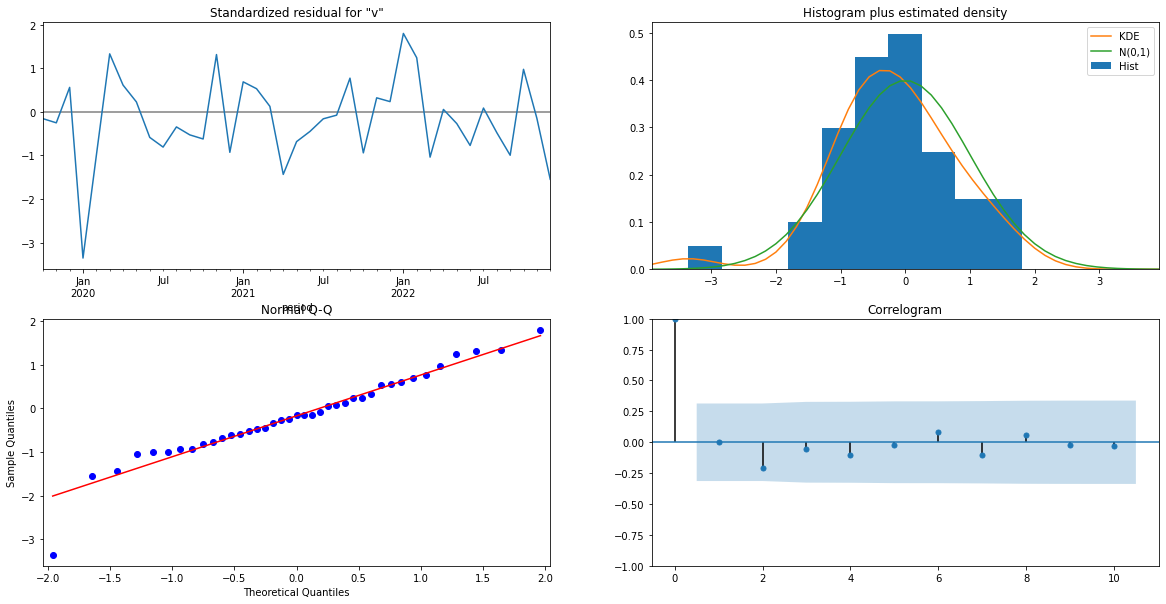

In [68]:
results.plot_diagnostics()
plt.show()

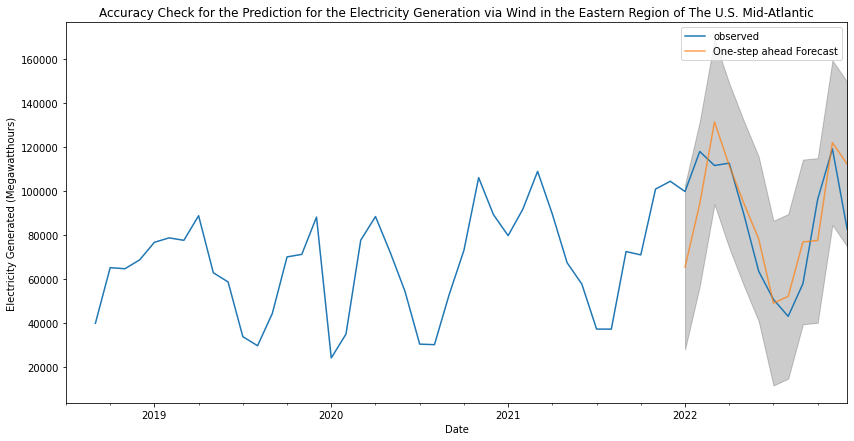

In [69]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = wnd['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [70]:
wnd_forecasted = pred.predicted_mean
wnd_truth = wnd['2022-01-01':]
mse = ((wnd_forecasted - wnd_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 337518693.02


In [71]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 18371.68


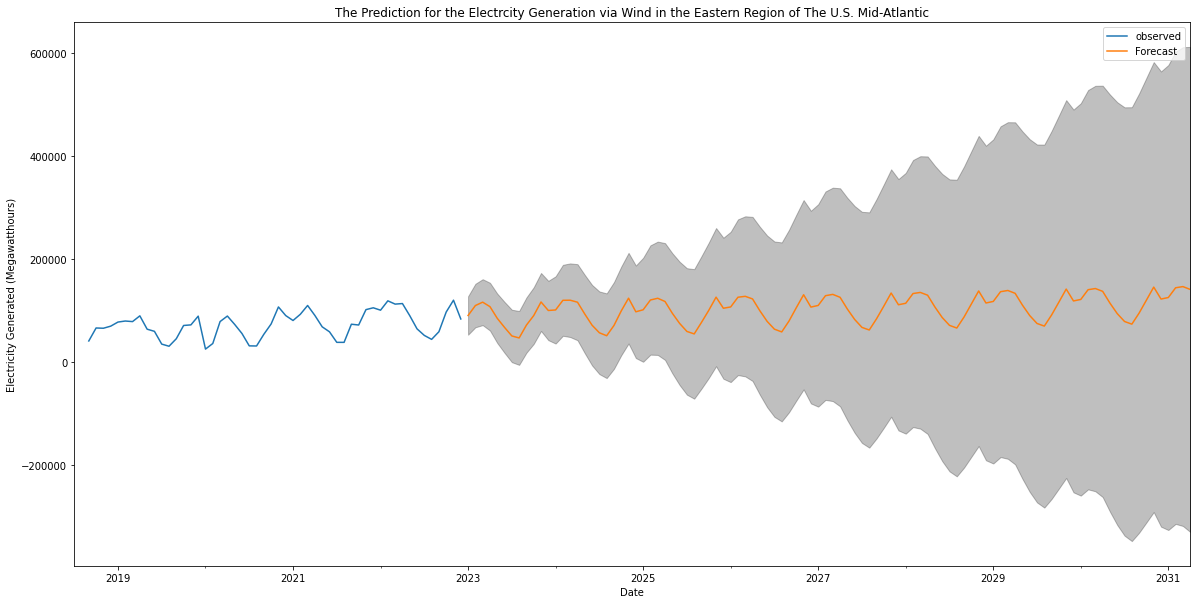

In [72]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = wnd.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Wind in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [73]:
othUrl = 'https://api.eia.gov/v2/electricity/rto/daily-fuel-type-data/data/?api_key=klobKyhl5dK7WfbXBlMzFkpf3tD0TYakCzvXgsQ7&frequency=daily&data[0]=value&facets[fueltype][]=OTH&facets[respondent][]=MIDA&facets[timezone][]=Eastern&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
r = requests.get(othUrl)
json_data = json.loads(r.text)

if r.status_code == 200:
    print('The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic:')
else:
    print('Error')

othDf = pd.DataFrame(json_data.get('response').get('data'))
othDf['period'] = pd.to_datetime(othDf['period'])

othDf = othDf.sort_values('period')
othDf.isnull().sum()

othDf = othDf.groupby('period')['value'].sum().reset_index()

othDf = othDf.set_index('period')
othDf.index

oth = othDf['value'].resample('MS').mean()

othDf

The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic:


,value
period,
2018-07-01,44423
2018-07-02,57745
2018-07-03,20024
2018-07-04,19373
2018-07-05,19883
...,...
2022-12-07,23255
2022-12-08,24188
2022-12-09,25295


>**Past Data, Present Data, and Prediction of the Energy Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic**

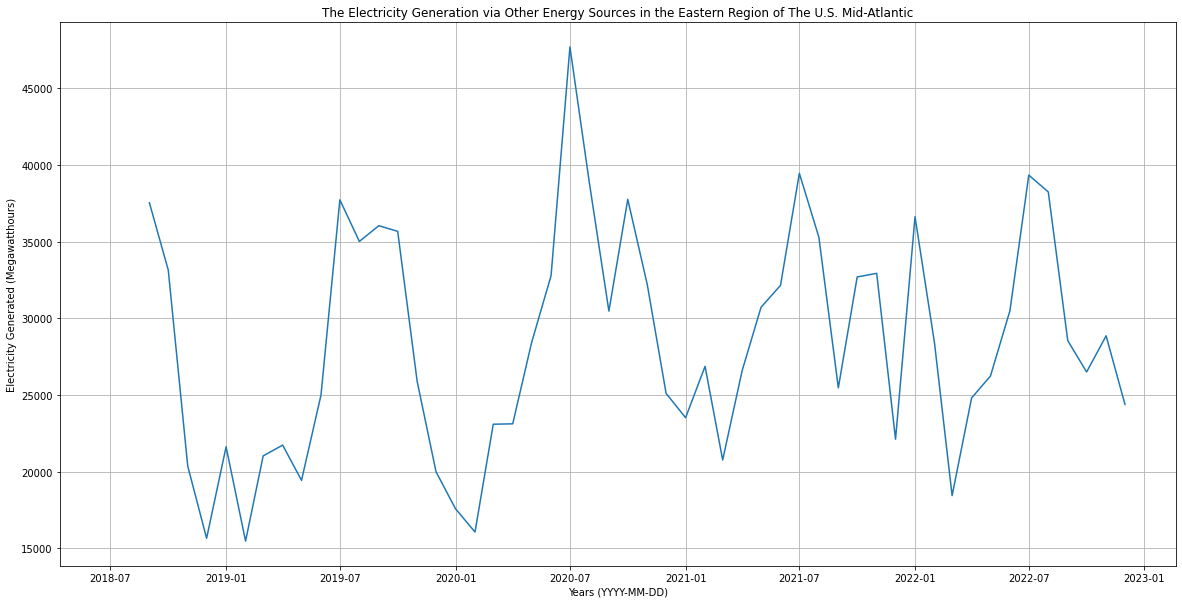

In [74]:

plt.rcParams["figure.figsize"] = (20,10)
plt.plot(oth)
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.show()

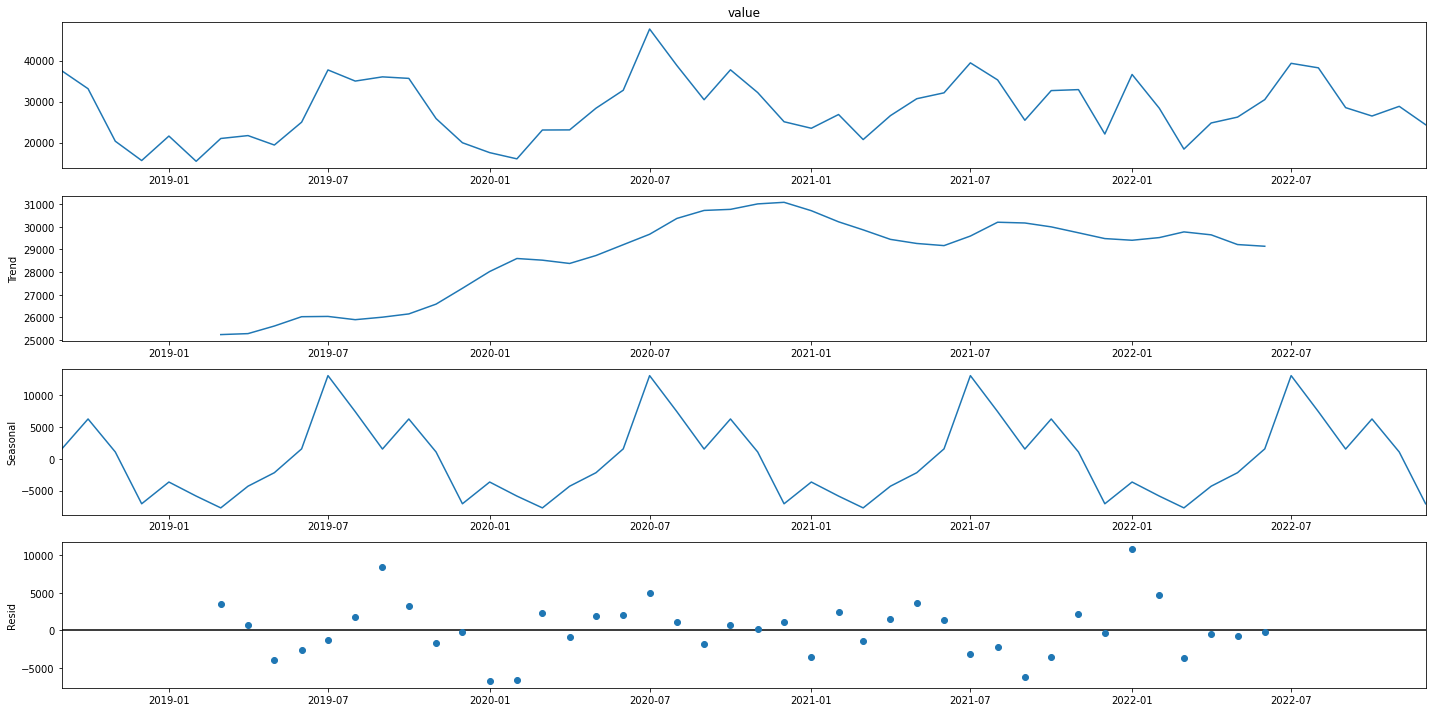

In [75]:
decomposition = sm.tsa.seasonal_decompose(oth['2018-09-01':], model='additive')
decomposition.plot()
plt.show()

In [76]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(oth['2018-09-01':],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1195.0819052683446
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:919.666737602416
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:779.3162079091363
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1066.4593704641086
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:799.9043896070132
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:777.1960151225195
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:560.251432503836
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:541.2284115278633
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1137.5946609424893
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:861.2232191491019
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:757.1907884977812
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1001.7191645773185
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:901.4320505241897
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:858.4722464760904
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:560.7139875917458
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:522.0284794227347
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1026.5264173099129
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:766.5578778826545
ARIMA(0

In [77]:
mod = sm.tsa.statespace.SARIMAX(oth['2018-09-01':],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4732      0.258      1.833      0.067      -0.033       0.979
ma.L1         -0.7804      0.200     -3.895      0.000      -1.173      -0.388
ar.S.L12       0.1410      0.141      1.001      0.317      -0.135       0.417
sigma2      2.899e+07   6.37e-10   4.55e+16      0.000     2.9e+07     2.9e+07


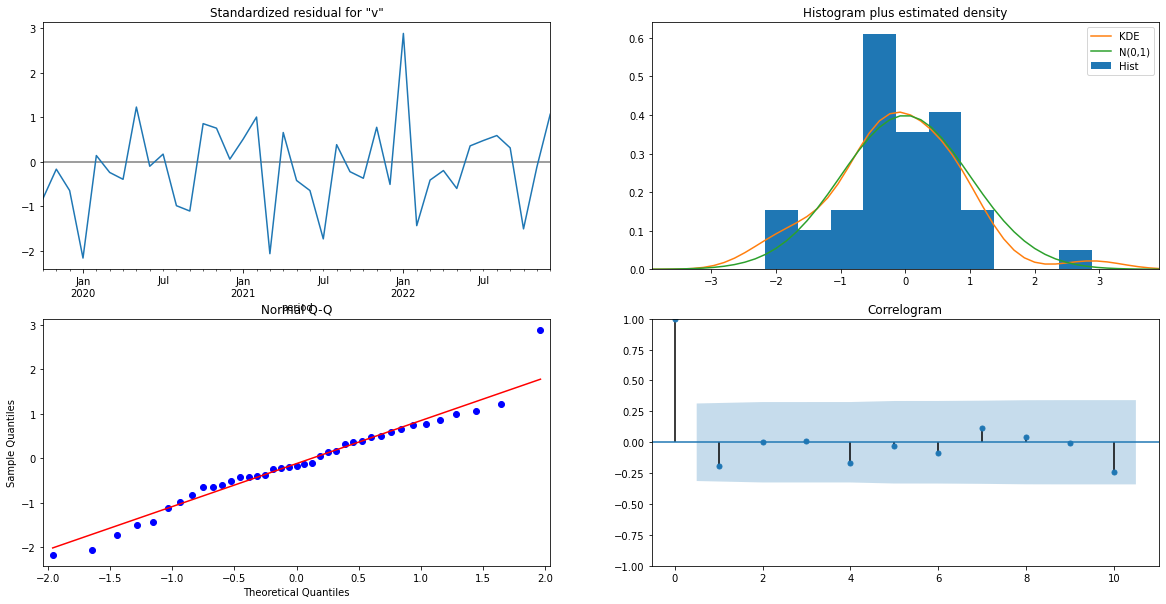

In [78]:
results.plot_diagnostics()
plt.show()

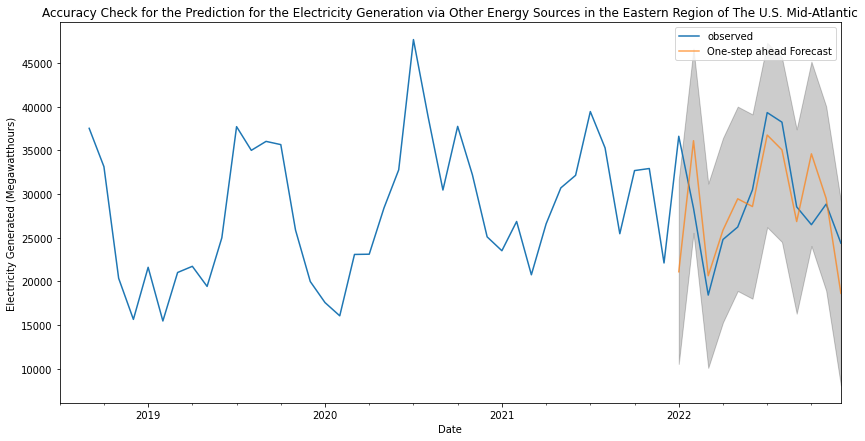

In [79]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = oth['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("Accuracy Check for the Prediction for the Electricity Generation via Other Energy Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

In [80]:
oth_forecasted = pred.predicted_mean
oth_truth = oth['2022-01-01':]
mse = ((oth_forecasted - oth_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36592594.96


In [81]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 6049.18


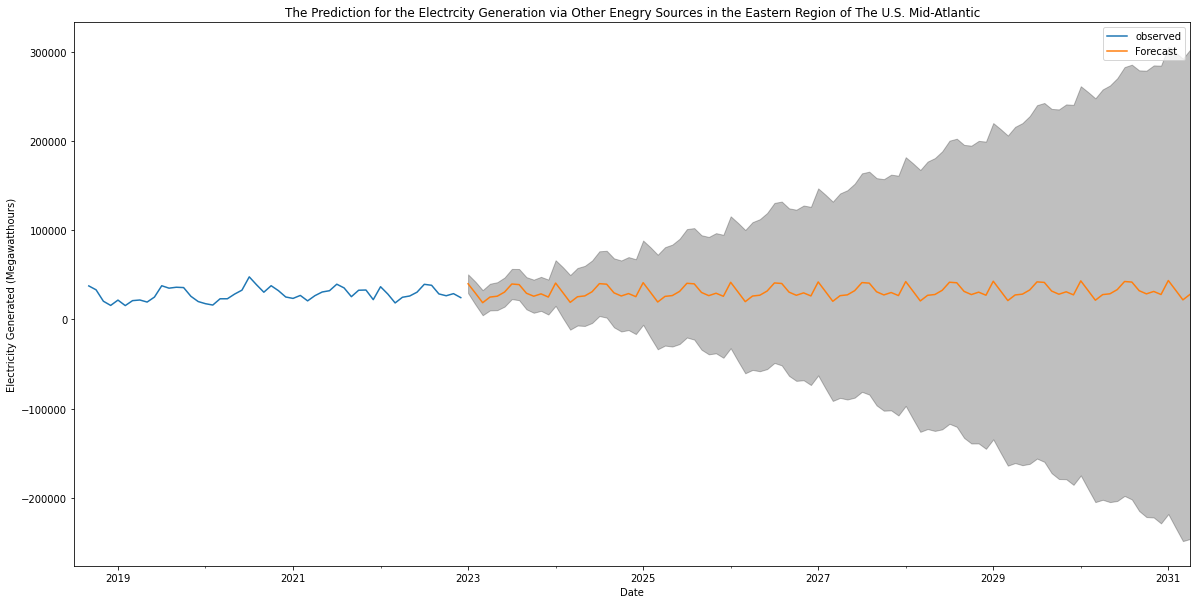

In [82]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = oth.plot(label='observed', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Generated (Megawatthours)')
plt.title("The Prediction for the Electrcity Generation via Other Enegry Sources in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()

>**Past and Present Data of the Energy Generation in the Eastern Region of The U.S. Mid-Atlantic**

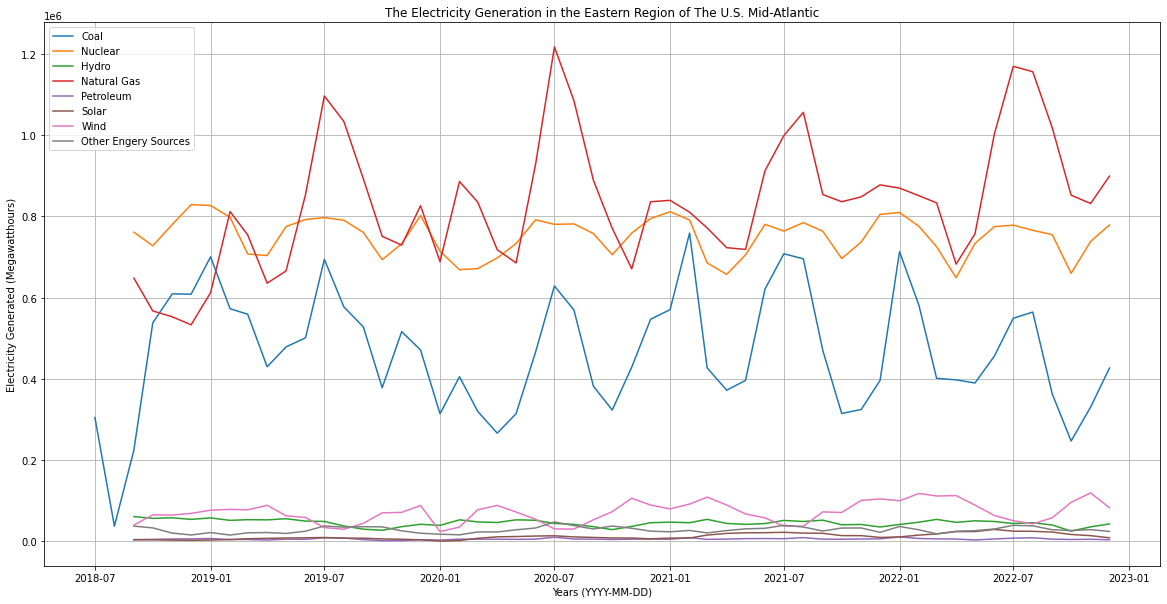

In [83]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(col, label = 'Coal')
plt.plot(nuc, label = 'Nuclear')
plt.plot(wat, label = 'Hydro')
plt.plot(ng, label = 'Natural Gas')
plt.plot(oil, label = 'Petroleum')
plt.plot(sun, label = 'Solar')
plt.plot(wnd, label = 'Wind')
plt.plot(oth, label = 'Other Engery Sources')
plt.grid()
plt.xlabel("Years (YYYY-MM-DD)")
plt.ylabel("Electricity Generated (Megawatthours)")
plt.title("The Electricity Generation in the Eastern Region of The U.S. Mid-Atlantic")
plt.legend()
plt.show()